# Tranining a language model to classify lines as contributing or non-contributing

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')


In [ ]:
!pip install transformers

In [ ]:
%matplotlib inline
import tensorflow as tf
import random
import os
import glob
import pandas as pd
from transformers import AutoModel, AutoTokenizer, TFAutoModelForSequenceClassification
import numpy as np
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

## Model training

In [ ]:
def load_dataset(filename) -> pd.DataFrame:
  return pd.read_csv(filename, header=0)

In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.callbacks import EarlyStopping, ModelCheckpoint


def Tokenizer():
    # Get the Bert Tokenizer
    return AutoTokenizer.from_pretrained("distilbert-base-uncased")


@tf.autograph.experimental.do_not_convert
def training(train_data, val_data) -> AutoModel:

    # fine-tune the model
    tokenizer = Tokenizer()

    # Tokenize train and validation data
    tokenized_train = tokenizer.batch_encode_plus(list(train_data["text"]),padding = "max_length", truncation=True, max_length =  max_len, return_tensors="tf")
    tokenizer = Tokenizer()
    tokenized_val = tokenizer.batch_encode_plus(list(val_data["text"]),padding = "max_length", truncation=True, max_length =  max_len, return_tensors="tf")
    print("----------------Tokenized input-----------------")
    train_labels = np.array(train_data["label"]).astype(np.float32)
    val_labels = np.array(val_data["label"]).astype(np.float32)

    # Load the pretrained model
    model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels = 2)
    print("---------loaded model--------------------")
    # Freeze all except the classification layer
    #model.bert.trainable = False

    #set Early stop to prevent overfitting
    es = EarlyStopping(monitor='val_loss', patience=1)  
    checkpoint_dir = "./checkpoints"
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint_callback = ModelCheckpoint(filepath=checkpoint_prefix, save_best_only=True, monitor='val_loss', mode='min')

    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-8)
    #Add L2 regularisation
    l2_reg = tf.keras.regularizers.l2(0.001)
    for w in model.trainable_variables:
        w = w + l2_reg(w)

    model.compile(optimizer=optimizer,loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    print("compiled model")
    model.fit(dict(tokenized_train),train_labels, validation_data=(dict(tokenized_val),val_labels), batch_size = 16, epochs = 5, callbacks=[es, checkpoint_callback])
    print("fitted")
    return model


def evaluate(dataset: pd.DataFrame, model: AutoModel):
   '''Evaluate the model'''

    tokenizer = Tokenizer()
    tokenized_data = tokenizer.batch_encode_plus(list(dataset["text"]),padding = "max_length", truncation=True, max_length =  max_len, return_tensors="tf")
    labels = np.array(dataset["label"]).astype(np.float32)
    results = model.evaluate(dict(tokenized_data), labels)
    return results


def predict(dataset: pd.DataFrame, model: AutoModel):
    '''Predictions from teh model'''

    tokenizer = Tokenizer()
    tokenized_data = tokenizer.batch_encode_plus(list(dataset["text"]),padding = "max_length", truncation=True, max_length =  max_len,  return_tensors="tf")
    labels = np.array(dataset["label"]).astype('float32')
    logits = model.predict(dict(tokenized_data))  # softmax returns logits
    return logits



## Data load and model evaluation

In [ ]:
data = load_dataset("training-data-master/filtered_data_rand.csv")
data['label'] = data['label'].astype(np.float32)
data = data.drop('Unnamed: 0', axis=1)
max_len = 256  # maximum sequence length for bert

# Test data
test_data = load_dataset("test-data-master/filtered_data.csv")
test_data['label'] = test_data['label'].astype(np.float32)
test_data = test_data.drop('Unnamed: 0', axis=1)

In [ ]:
data.head()  #display data

In [ ]:
train_dataset, val_dataset = train_test_split(data, test_size=0.3, random_state=42)  # split the dataset into train and test

In [ ]:
model = training(train_dataset, val_dataset)  # train

In [ ]:
model.save_pretrained('model_checkpoint/')
!cp -r model_checkpoint/ "/content/drive/My Drive/model_checkpoint/"

In [ ]:
# Running model with new test data
logits = predict(test_data,model)
results = np.argmax(logits["logits"], axis=1).flatten()
confusion_matrix_test = confusion_matrix(test_data["label"], results, normalize="true")
confusion_matrix_test.ravel()

In [ ]:
#Evaluating with validation data
logits = predict(val_dataset,model)
results = np.argmax(logits["logits"], axis=1).flatten()
confusion_matrix_eval = confusion_matrix(val_dataset["label"], results, normalize="true")
confusion_matrix_eval.ravel() #(tn, fp, fn, tp)

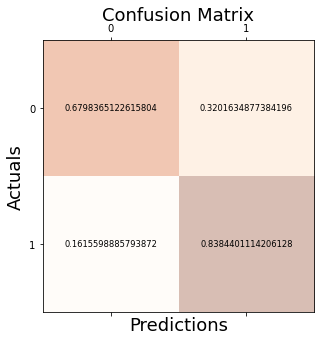

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(confusion_matrix_eval, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(confusion_matrix_eval.shape[0]):
  for j in range(confusion_matrix_eval.shape[1]):
    ax.text(x=j, y=i,s=confusion_matrix_eval[i, j], va='center', ha='center', size='small')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
print('Precision: %.3f' % precision_score(val_dataset["label"], results))
print('Recall: %.3f' % recall_score(val_dataset["label"], results))
print('F1 Score: %.3f' % f1_score(val_dataset["label"], results))
print('Accuracy: %.3f' % accuracy_score(val_dataset["label"], results))

Precision: 0.719
Recall: 0.838
F1 Score: 0.774
Accuracy: 0.758
